In [19]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import dill
import sys
sys.path.append('../')
from modelfitting import train_test_split, ROC_curve, PR_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction

In [20]:
datapath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/training_data/'
dset = 'resonant/'
featurefolder = 'spock_featuresv2Norbits10000.0Nout1000/'
features = ['MEGNO']

In [21]:
trainingdatafolder = datapath+dset+featurefolder
trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features)

# Fraction not chaotic over 1e4 orbits

In [22]:
(testX['MEGNO']<2.5).sum()/testX['MEGNO'].shape[0]

0.515

# Fraction not chaotic over 1e4 orbits that were stable

In [26]:
regular = testX['MEGNO'] < 2.5
testY[regular].sum()/testY[regular].shape[0]

0.5

# Fraction chaotic over 1e4 orbits that were stable

In [28]:
chaotic = testX['MEGNO'] > 2.5
testY[chaotic].sum()/testY[chaotic].shape[0]

0.029714285714285714

In [10]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 15),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'], seed = 0)
    
    params = clf.get_xgb_params()
    #dtest
    score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    #print score
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    test_score = metrics.roc_auc_score(testY, preds)
    
    print("SCORE:", avg_score, "ERROR", error, "HOLDOUT SCORE", test_score)

    return{'loss':1-test_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error, "holdout":test_score }

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [11]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.83911546                                          
ERROR                                               
0.007397955303322839                                
HOLDOUT SCORE                                       
0.8420967948320008                                  
SCORE:                                                                        
0.84805268                                                                    
ERROR                                                                         
0.009003239698780446                                                          
HOLDOUT SCORE                                                                 
0.8504552658684259                                                            
SCORE:                                                                        
0.81485558                                                                   
ERROR                                              

HOLDOUT SCORE                                                                  
0.8559942178004076                                                             
SCORE:                                                                         
0.5                                                                            
ERROR                                                                          
0.0                                                                            
HOLDOUT SCORE                                                                  
0.5                                                                            
SCORE:                                                                         
0.8411352200000002                                                             
ERROR                                                                          
0.008595777717075308                                                           
HOLDOUT SCORE                           

In [12]:
best

{'x_learning_rate': 0.15863212986365377,
 'x_max_depth': 4,
 'x_min_child': 3.0,
 'x_pos_weight': 5.560186342752907,
 'x_subsample': 0.8876820051714283,
 'x_tree_colsample': 0.8980348921337582}

In [13]:
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])
params = best_xgbc.get_xgb_params()
score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", verbose_eval=True)
print(score)
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
bst = xgb.train(params, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print(score)

[0]	train-auc:0.855606+0.00338722	test-auc:0.846805+0.0134767
[1]	train-auc:0.858883+0.00380681	test-auc:0.84951+0.0140119
[2]	train-auc:0.861209+0.00288483	test-auc:0.852582+0.0121558
[3]	train-auc:0.862314+0.0024286	test-auc:0.852613+0.0120227
[4]	train-auc:0.863258+0.00222221	test-auc:0.852954+0.0119838
[5]	train-auc:0.863762+0.00191697	test-auc:0.85365+0.0124561
[6]	train-auc:0.86433+0.00205575	test-auc:0.853068+0.0130048
[7]	train-auc:0.864766+0.00251031	test-auc:0.854206+0.0110308
[8]	train-auc:0.864948+0.00258275	test-auc:0.854296+0.010943
[9]	train-auc:0.865269+0.00261607	test-auc:0.854641+0.0107464
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.855606       0.003387       0.846805      0.013477
1        0.858883       0.003807       0.849510      0.014012
2        0.861209       0.002885       0.852582      0.012156
3        0.862314       0.002429       0.852613      0.012023
4        0.863258       0.002222       0.852954      0.011984
5        0.86

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [14]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

model.fit(trainX, trainY)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.8980348921337582, gamma=0,
              learning_rate=0.15863212986365377, max_delta_step=0, max_depth=4,
              min_child_weight=3.0, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5.560186342752907,
              seed=None, silent=True, subsample=0.8876820051714283)

Text(0.5, 1.0, 'ROC curve (AUC = 0.855)')

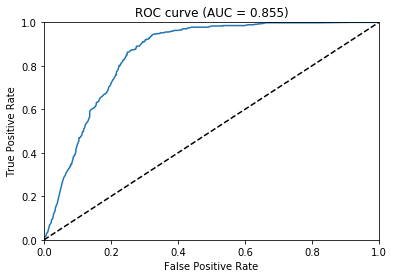

In [15]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [16]:
pr_auc, precision, recall, PRthresholds = PR_curve(trainingdatafolder, model, features)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(PRthresholds[i], recall[i], precision[i]))

Threshold 0.00947501603513956, recall = 1.0, precision = 0.2883795309168444
Threshold 0.076960988342762, recall = 0.9944547134935305, precision = 0.361316319677636
Threshold 0.12016501277685165, recall = 0.9833641404805915, precision = 0.4120836560805577
Threshold 0.16170251369476318, recall = 0.977818853974122, precision = 0.440466278101582
Threshold 0.20741595327854156, recall = 0.9704251386321626, precision = 0.46093064091308167
Threshold 0.3032134771347046, recall = 0.9630314232902033, precision = 0.47710622710622713
Threshold 0.4080152213573456, recall = 0.955637707948244, precision = 0.4895833333333333
Threshold 0.5109516978263855, recall = 0.9463955637707948, precision = 0.512
Threshold 0.5915945768356323, recall = 0.922365988909427, precision = 0.5247108307045215
Threshold 0.637490451335907, recall = 0.9094269870609981, precision = 0.5330444203683641
Threshold 0.6782559156417847, recall = 0.8761552680221811, precision = 0.5435779816513762
Threshold 0.7200483679771423, recall = 

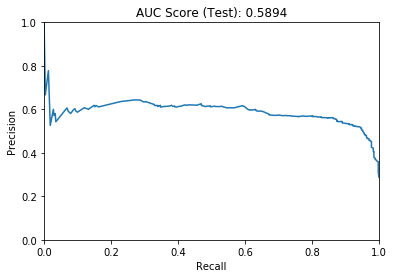

In [17]:
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title("AUC Score (Test): {0:.4f}".format(pr_auc))
plt.show()

(0, 18.700000000000003)

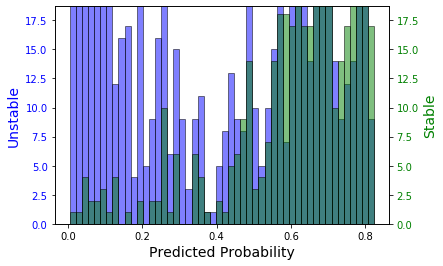

In [16]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
#print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
#print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,1.1*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100

Text(0, 0.5, 'Fraction actually stable')

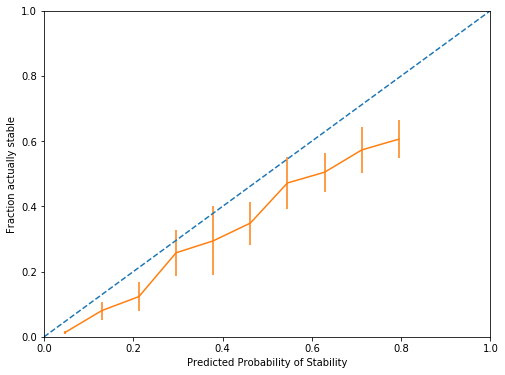

In [17]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

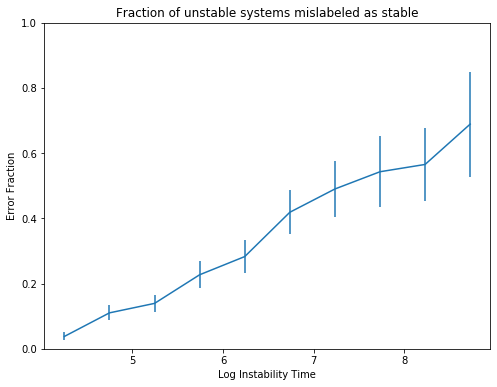

In [18]:
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')

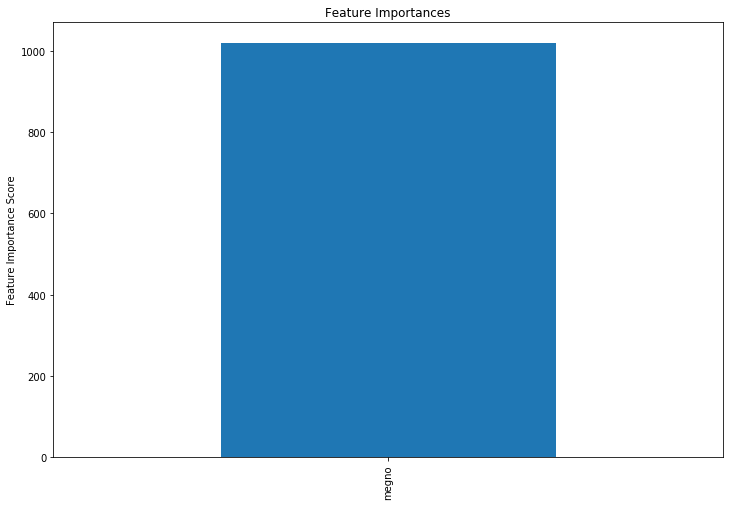

In [19]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

In [18]:
dill.dump([model, features, featurefolder], open(datapath+"../models/megnov2_resonant.pkl", "wb"))

# Test how many non-chaotic systems were unstable

In [5]:
model, features, featurefolder = dill.load(open(datapath+"../models/megnoxgb_resonant.pkl", "rb")) 

In [8]:
chaotic = testX['megno'] > 2.5
nonchaotic = ~chaotic
stable = testY
unstable = ~testY

In [9]:
unstable[nonchaotic].sum()/nonchaotic.sum()

0.5394853593611357

In [7]:
stable[chaotic].sum()/chaotic.sum()

0.025200458190148912

In [ ]:
unstable = ~testY
unstable[~chaotic].sum()/(~)

In [10]:
nonchaotic.sum()

1127

In [11]:
chaotic.sum()

873